# SHAPIQ Library Tools

SHAPIQ library has offers different visualizations. These are introduced here. 
1. Dataset preprocessing, Model Training, Testing, Evaluation Metrics
2. Global Explanation Plots
3. Local Explanation Plots

## 1. Dataset preprocessing, Model Training, Testing, Evaluation Metrics

In [1]:
# Uncomment the libraries not installed
#!pip install numpy
#!pip install matplotlib
#!pip install pandas
#!pip install scikit-learn
#!pip install xgboost
#!pip install shapiq

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shapiq
from tqdm.asyncio import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:

drop_list = ['symmetry_worst', 'area_worst', 'symmetry_se','radius_mean','concave points_worst',
            'compactness_se', 'concavity_se','smoothness_se','perimeter_mean','concave points_mean',
            'texture_se','radius_se','smoothness_mean','texture_mean','concave points_se',
            'area_mean','compactness_mean','perimeter_worst','Unnamed: 32', 'id']
#importing our cancer dataset
dataset = pd.read_csv('data.csv')
dataset = dataset.drop(drop_list, axis = 1)
X = dataset.drop(['diagnosis'], axis = 1)
Y = dataset['diagnosis']

In [4]:
#Encoding categorical data values
labelencoder_Y = LabelEncoder()
Y = labelencoder_Y.fit_transform(Y)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

In [6]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [7]:
classifier = xgb.XGBClassifier()
classifier.fit(X_train_scaled, Y_train)
Y_pred = classifier.predict(X_test_scaled)

In [8]:
print(metrics.classification_report(Y_test, Y_pred))
print(metrics.confusion_matrix(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        90
           1       0.95      0.98      0.96        53

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143

[[87  3]
 [ 1 52]]


In [9]:
# set feature names to classifier
classifier.feature_names = list(X.columns.values)

## 2. Global Explanation Plots

### i. The bar plot below is based on feature interaction caclculations until order 2: 

In [10]:
%%capture
explanations_si = []
explainer = shapiq.TreeExplainer(model=classifier, max_order=2, index="k-SII", verbose=False)
for instance_id in tqdm(range(len(X_test))):
    x_explain = X_test_scaled[instance_id]
    si = explainer.explain(x=x_explain, verbose=False)
    explanations_si.append(si)

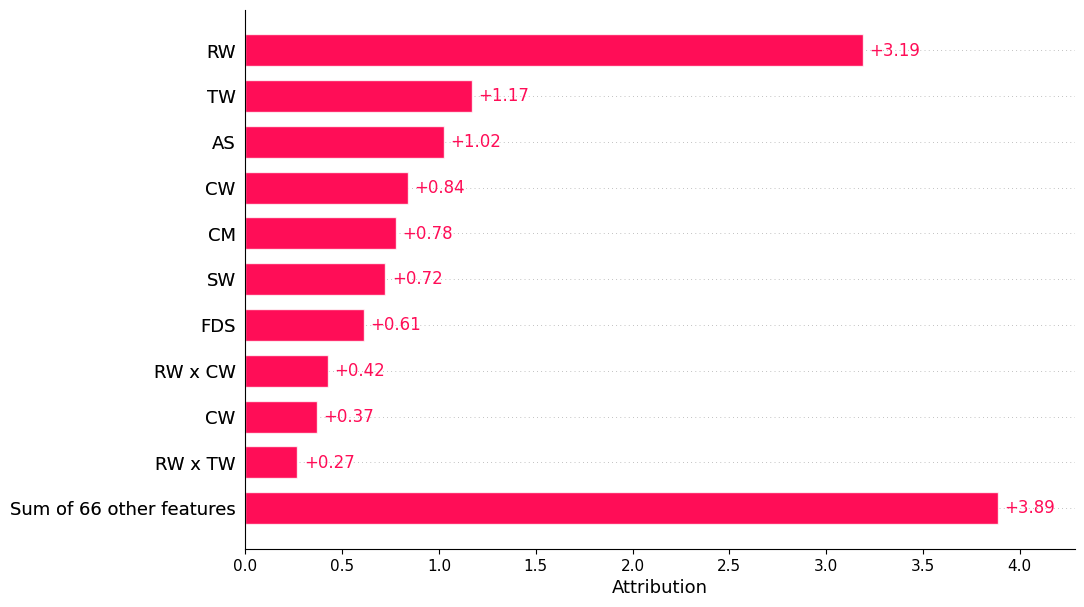

In [11]:
shapiq.plot.bar_plot(explanations_si, feature_names=classifier.feature_names, show=True)

In [12]:
explanations_si[0].interaction_lookup

{(): 0,
 (np.int64(0),): 1,
 (np.int64(3),): 2,
 (np.int64(5),): 3,
 (np.int64(6),): 4,
 (np.int64(7),): 5,
 (np.int64(9),): 6,
 (np.int64(11),): 7,
 (np.int64(0), np.int64(3)): 8,
 (np.int64(0), np.int64(5)): 9,
 (np.int64(0), np.int64(6)): 10,
 (np.int64(0), np.int64(7)): 11,
 (np.int64(0), np.int64(9)): 12,
 (np.int64(0), np.int64(11)): 13,
 (np.int64(3), np.int64(5)): 14,
 (np.int64(3), np.int64(6)): 15,
 (np.int64(3), np.int64(7)): 16,
 (np.int64(3), np.int64(9)): 17,
 (np.int64(3), np.int64(11)): 18,
 (np.int64(5), np.int64(6)): 19,
 (np.int64(5), np.int64(7)): 20,
 (np.int64(5), np.int64(9)): 21,
 (np.int64(5), np.int64(11)): 22,
 (np.int64(6), np.int64(7)): 23,
 (np.int64(6), np.int64(9)): 24,
 (np.int64(6), np.int64(11)): 25,
 (np.int64(7), np.int64(9)): 26,
 (np.int64(7), np.int64(11)): 27,
 (np.int64(9), np.int64(11)): 28,
 (np.int64(1),): 29,
 (np.int64(4),): 30,
 (np.int64(8),): 31,
 (np.int64(10),): 32,
 (np.int64(1), np.int64(4)): 33,
 (np.int64(1), np.int64(6)): 34,
 (n

In [13]:
len(explanations_si[0].values)

77

### In my calculation, there should be (12C1 + 12C2 + 12C0 = 12 + 66 + 1) = 79 values calculated for each data point when they are saying that they are calculating interactions until order2. But there are 77 values here. What happens to the remaining 2 values? 

Question: I further looked up into all the combinations above and found out that the listed interactions are missing these - (np.int64(1), np.int64(2)) and (np.int64(10), np.int64(11)) interactions. Isn't this a mistake that invalidates the library's calculations, since they are disregarding these feature combinations altogether, and all other calculations using this library are based on these interaction calculations?

### iii. The bar plot below is based on all feature interactions:

In [14]:
%%capture
explanations_mi = []
explainer = shapiq.TreeExplainer(model=classifier, max_order=len(classifier.feature_names), index="k-SII")
for instance_id in tqdm(range(len(X_test))):
    x_explain = X_test_scaled[instance_id]
    mi = explainer.explain(x=x_explain)
    explanations_mi.append(mi)

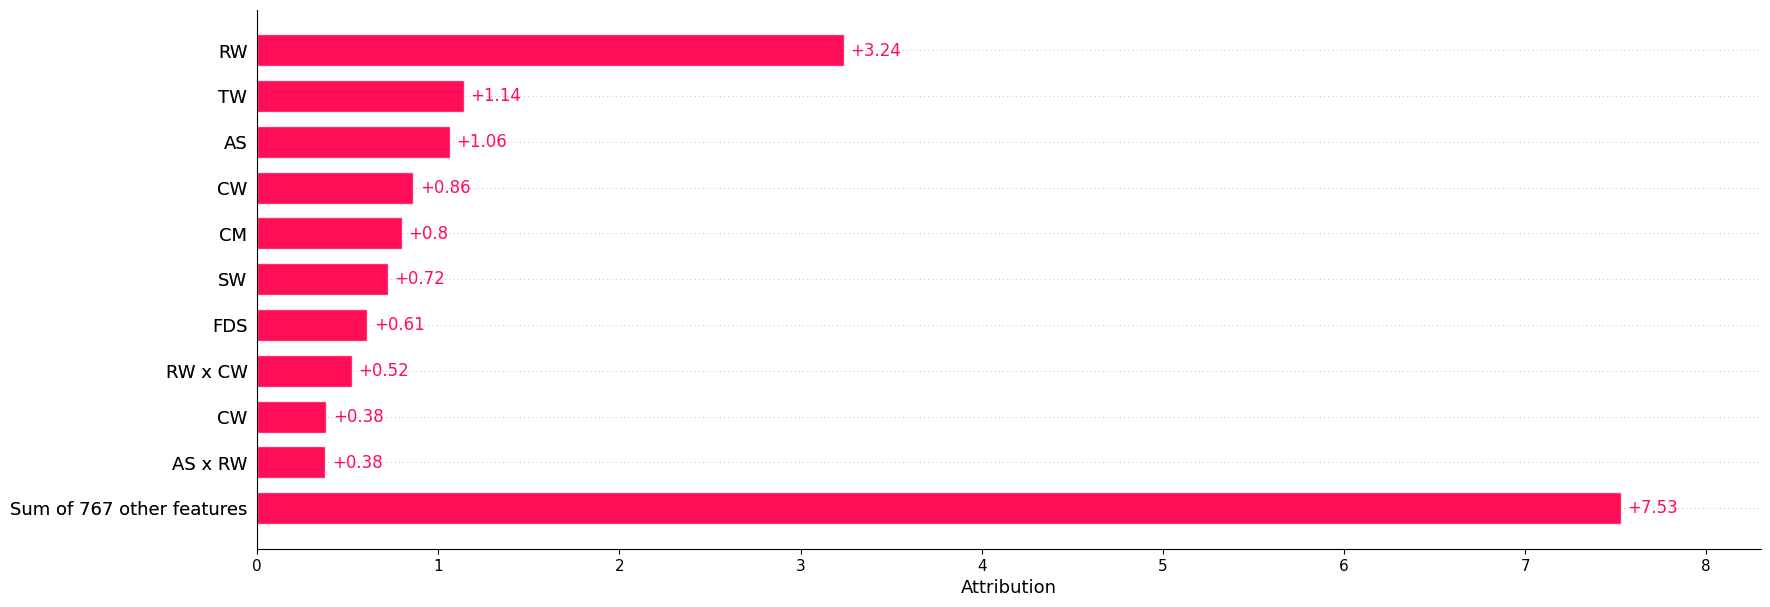

In [15]:
shapiq.plot.bar_plot(explanations_mi, feature_names=classifier.feature_names, show=True)

In [16]:
len(explanations_mi[0])

778

## 3. Local Explanation Plots

Selecting instance from the test dataset to explain 

In [17]:
def explain_instance(classifier, X_test, X_test_scaled, Y_test, instance_id):
    """
    Prints and returns the actual values, scaled values, and prediction for a selected instance.
    
    Parameters:
        classifier  : Trained model with feature names
        X_test      : DataFrame of test features (actual values)
        X_test_scaled : Scaled version of X_test (numpy array)
        Y_test      : True labels for the test set
        instance_id : Index of the instance to be explained
        
    Returns:
        dict: Contains actual values, scaled values, true label, and predicted value
    """
    x_explain_actual = X_test.iloc[instance_id]
    x_explain_scaled = X_test_scaled[instance_id]
    y_true = Y_test[instance_id]
    y_pred = classifier.predict(x_explain_scaled.reshape(1, -1))[0]
    
    # Print formatted output
    print(f"\n{'Feature Name':<25}{'Actual Value':<15}{'Scaled Value':<15}")
    print("=" * 50)
    for i, feature in enumerate(classifier.feature_names):
        print(f"{feature:<25}{x_explain_actual[i]:<15}{x_explain_scaled[i]:<15.4f}")

    print("\n" + "=" * 50)
    print(f"Instance ID     : {instance_id}")
    print(f"True Value      : {y_true}")
    print(f"Predicted Value : {y_pred}")
    print("=" * 50)
    
    return {
        "actual_values": x_explain_actual.to_dict(),
        "scaled_values": x_explain_scaled,
        "true_label": y_true,
        "predicted_label": y_pred
    }

### i. Force Plot

#### Calculating interaction values for order 1, 2, and all features: 

In [18]:
%%capture
# selecting an instance from the test dataset to explain using SHAPIQ
instance_id = 0
explain_this_record = explain_instance(classifier=classifier, X_test=X_test, X_test_scaled=X_test_scaled, Y_test=Y_test, instance_id=instance_id)

# create explanations for different orders
si_order: dict[int, shapiq.InteractionValues] = {}
for order in tqdm([1, 2, len(classifier.feature_names)]):
    index = "k-SII" if order > 1 else "SV"  # will also be set automatically by the explainer
    explainer = shapiq.Explainer(model=classifier, max_order=order, index=index)
    si_order[order] = explainer.explain(x=explain_this_record['scaled_values'])
si_order

#### Visualizing Interactions of order 1 (since it is limited to order 1 only, it should be the same as SHAP values): 

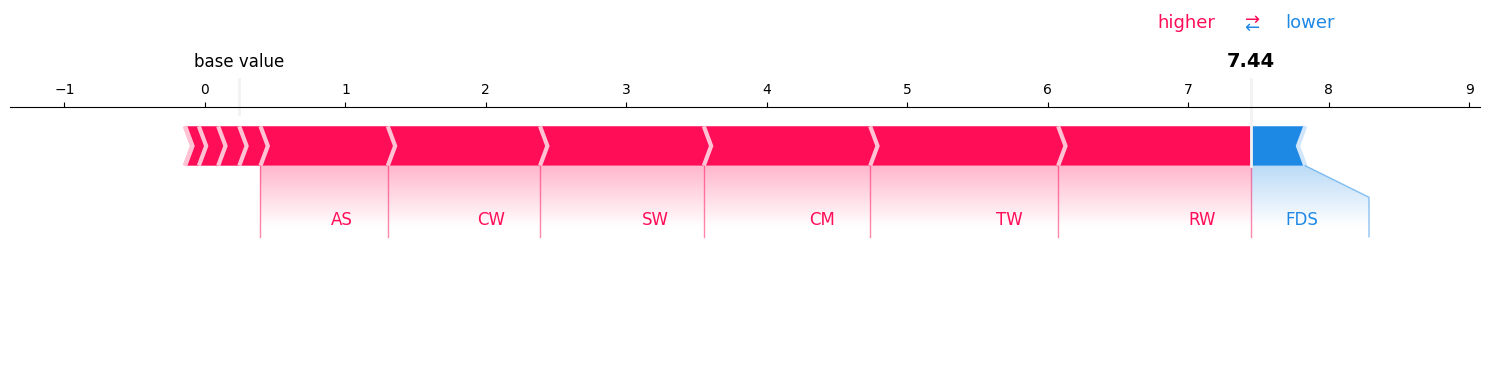

In [19]:
sv = si_order[1]  # get the SV

sv.plot_force(feature_names=classifier.feature_names, show=True)

#### Visualizing interactions of order until 2: 

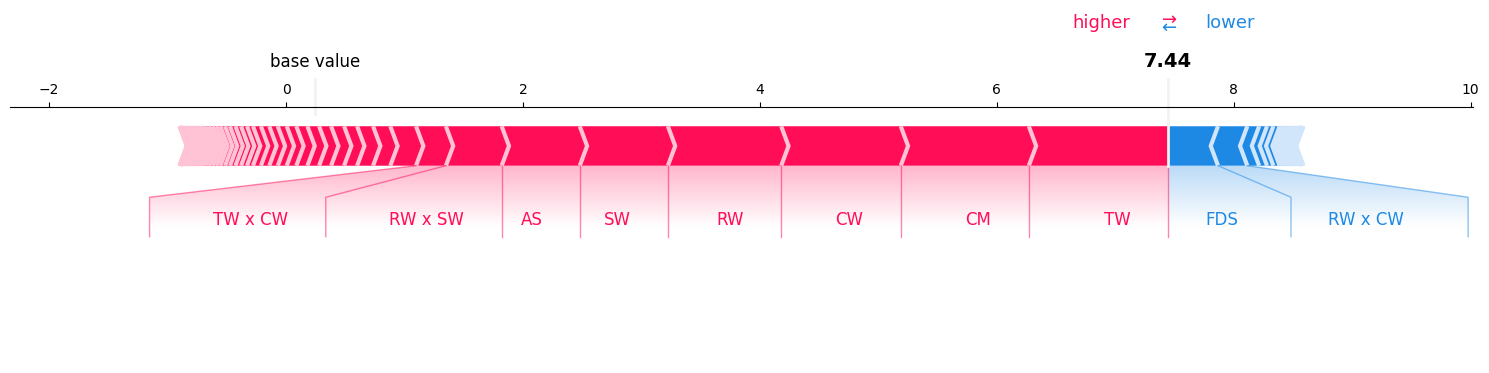

In [20]:
si = si_order[2]  # get the 2-SII

si.plot_force(feature_names=classifier.feature_names, show=True)

#### Visualizing All feature interactions: 

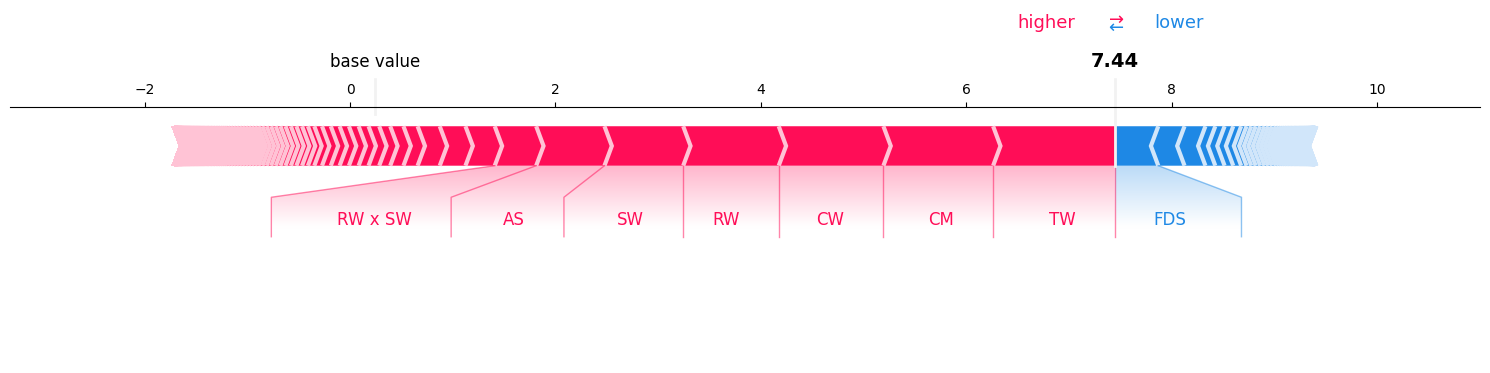

In [21]:
mi = si_order[len(classifier.feature_names)]  # get the Moebius transform

mi.plot_force(feature_names=classifier.feature_names, show=True)

In [22]:
print("model prediction in log-odds space: ", np.log(classifier.predict_proba(explain_this_record['scaled_values'].reshape(1, -1))[0][1] / classifier.predict_proba(explain_this_record['scaled_values'].reshape(1, -1))[0][0]))

model prediction in log-odds space:  6.552892


So, sum of the shap values and baseline_value is also not equal to the model's output in the log-odds space.

### ii. Waterfall Plot

#### Visualizing Feature Interactions until order 1 (the same as SHAP values):

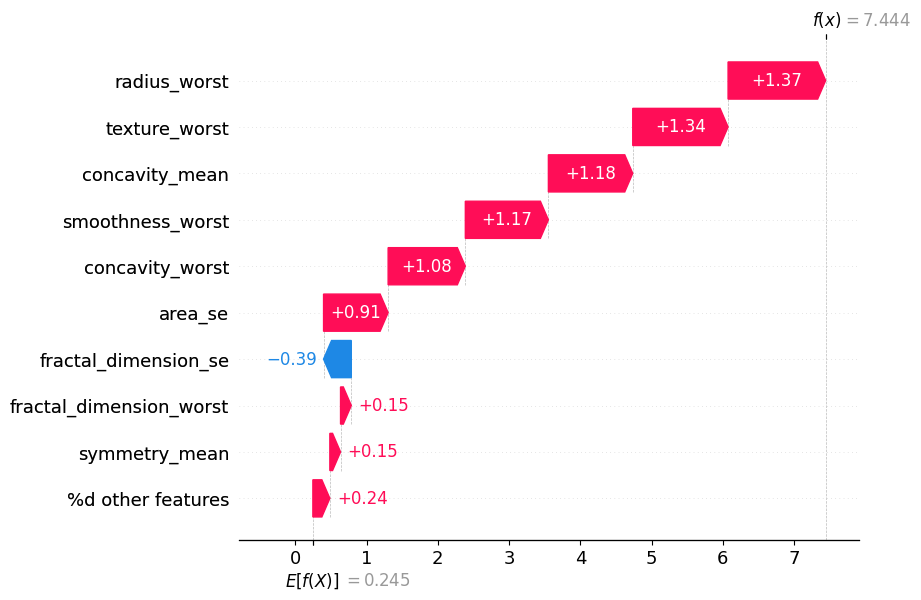

In [23]:
sv.plot_waterfall(feature_names=classifier.feature_names, show=True, abbreviate=False)

#### Visualizing Feature Interactions until order 2: 

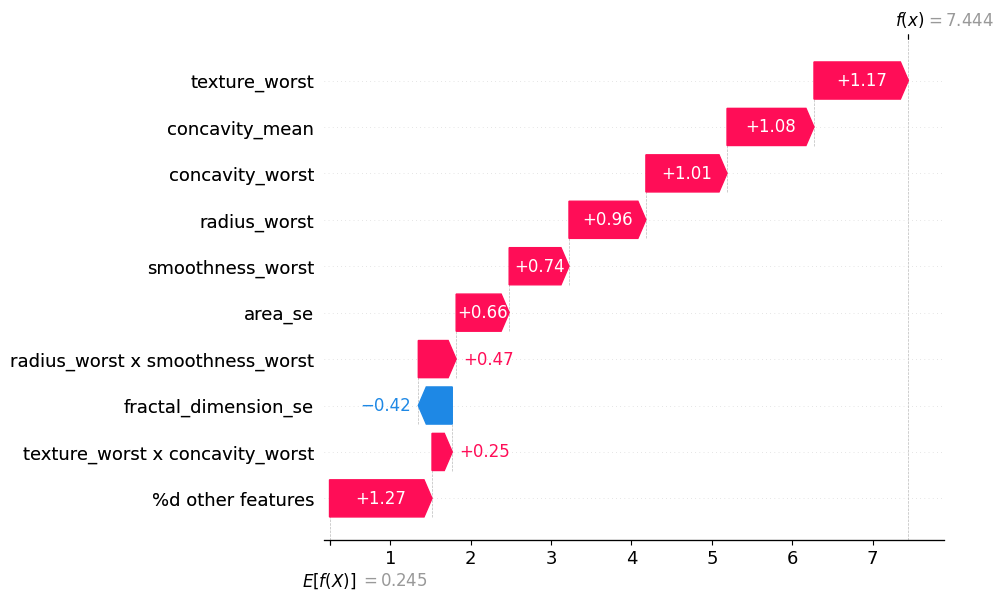

In [24]:
si.plot_waterfall(feature_names=classifier.feature_names, show=True, abbreviate=False)

#### Visualizing the impact of all feature interactions: 

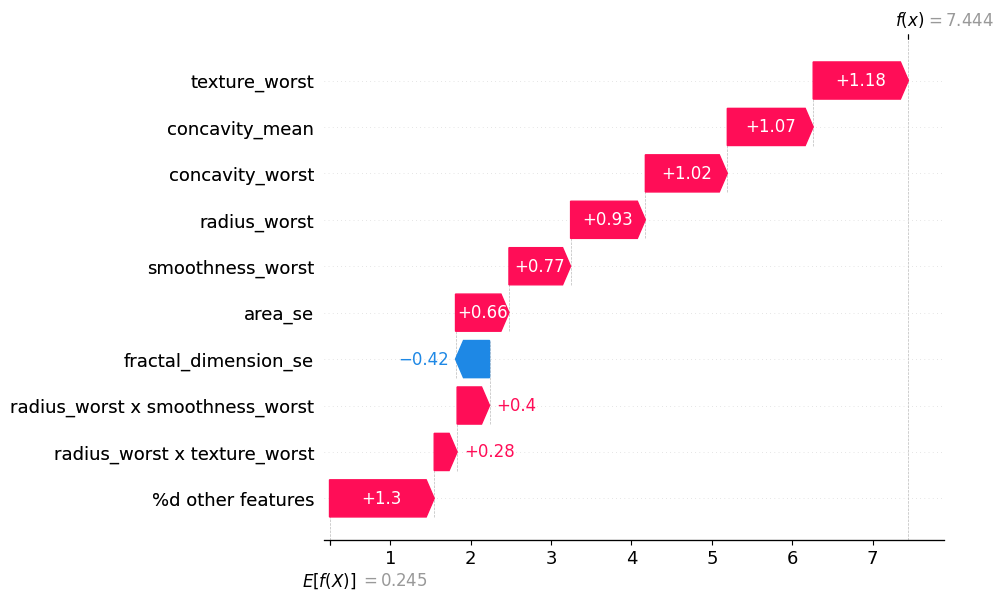

In [25]:
mi.plot_waterfall(feature_names=classifier.feature_names, show=True, abbreviate=False)

### iii. Network Plot

Network Plot notes: 
1. The network plot visualizes all first- and second-order interactions of computed Shapley Interactions.
2. It does plot all second order interactions.
3. Color Scheme: positive interactions are shown in red, negative interactions in blue.
4. The strength of an interaction is encoded in the width of the edge connecting the two features.
5. The strength of a first-order interaction is encoded in the size of the node for the respective feature.
6. The second-order interactions are also plotted with a decreasing opacity depending on the strength of the interaction.

#### Visualizing Network Plot for interaction order until 2: 

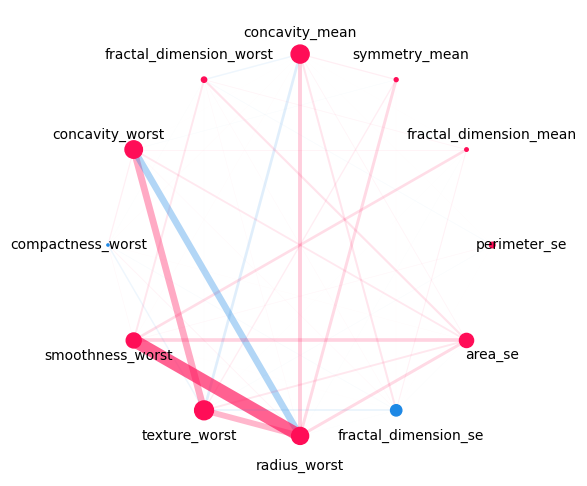

In [26]:
si.plot_network(feature_names=classifier.feature_names, show=True, draw_legend=False)

#### Visualizing Network Plot for all interaction orders: 

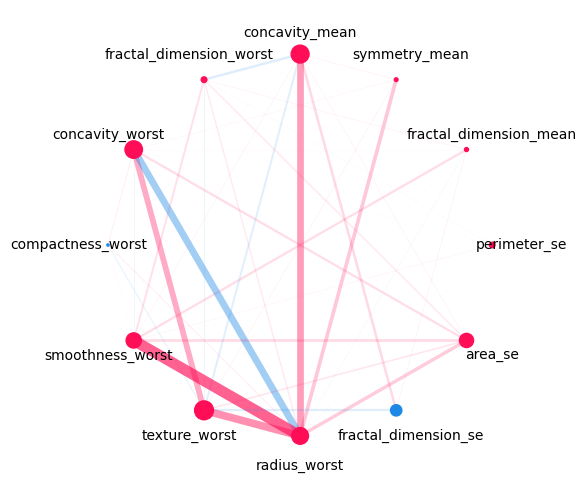

In [27]:
mi.plot_network(feature_names=classifier.feature_names, show=True, draw_legend=False)

### iii. SI Graph Plot

SI Graph notes: 
1. The nodes are the features,
2. The edges are the interactions between the features.
3. Interactions between more than two features are visualized as a hyper-edge.
4. Color scheme: red for positive interactions, blue for negative interactions.
5. The strength of an interaction is encoded in the width of the edge connecting the two features.
6. The strength of a first-order interaction is encoded in the size of the node for the respective feature.
7. The transparency of the edge/node is used to encode the strength of the interaction/feature attribution.

#### Visualizing feature interactions until first order in SI Graph Plot (this makes this an alternative to ): 

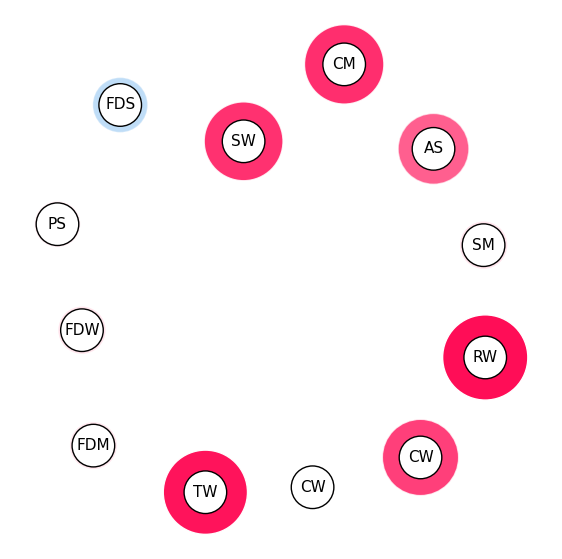

In [28]:
# we abbreviate the feature names since, they are plotted inside the nodes
abbrev_feature_names = shapiq.plot.utils.abbreviate_feature_names(classifier.feature_names)
sv.plot_si_graph(
    feature_names=abbrev_feature_names, show=True, size_factor=2.5, node_size_scaling=1.5
)

#### Visualizing feature interactions until second order in SI Graph Plot: 

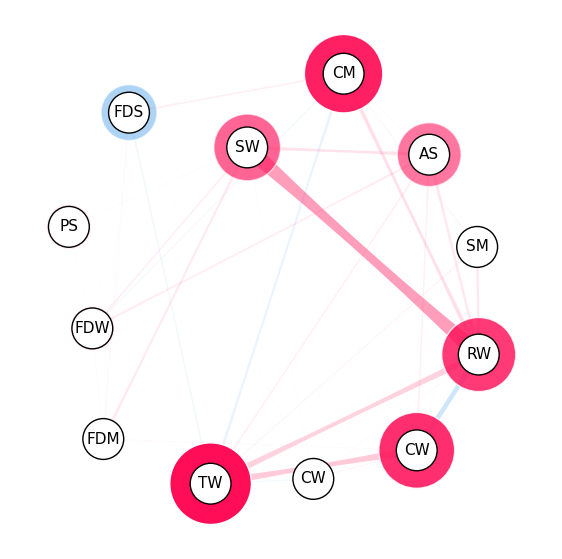

In [29]:
# we abbreviate the feature names since, they are plotted inside the nodes
abbrev_feature_names = shapiq.plot.utils.abbreviate_feature_names(classifier.feature_names)
si.plot_si_graph(
    feature_names=abbrev_feature_names, show=True, size_factor=2.5, node_size_scaling=1.5
)


#### Visualizing all feature interactions in SI Graph Plot: 

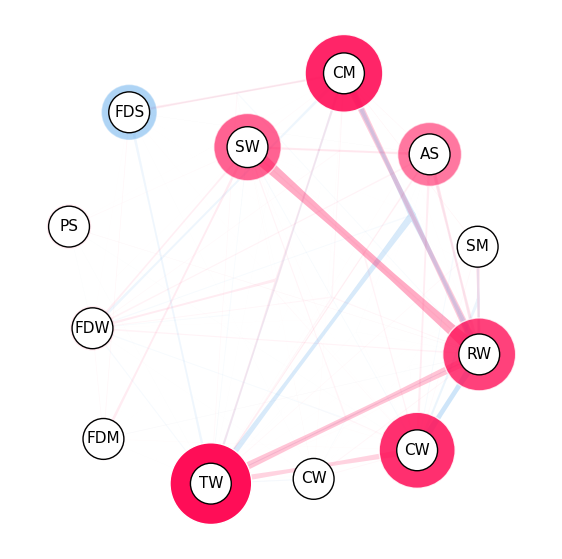

In [30]:
# we abbreviate the feature names since, they are plotted inside the nodes
abbrev_feature_names = shapiq.plot.utils.abbreviate_feature_names(classifier.feature_names)
mi.plot_si_graph(
    feature_names=abbrev_feature_names, show=True, size_factor=2.5, node_size_scaling=1.5
)